# A closer look at Ekman pumping around Antarctica
The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/Ekman_pumping/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44111 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [12]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'
end_time='2164-12-31'

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-50.04)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

## Compute Ekman pumping
Note that this is lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

In [5]:
# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(control,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice)

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians

In [13]:
tau_x_con = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_con = tau_x_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_con = tau_y_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_con = tau_y_con.load()

tau_x_up = cc.querying.getvar(easterlies_up, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_up = tau_x_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_up = tau_x_up.load()

tau_y_up = cc.querying.getvar(easterlies_up, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_up = tau_y_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_up = tau_y_up.load()

tau_x_down = cc.querying.getvar(easterlies_down, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_down = tau_x_down.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_down = tau_x_down.load()

tau_y_down = cc.querying.getvar(easterlies_down, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_down = tau_y_down.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_down = tau_y_down.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23334243174208 and this is thread id 23331639121664.
Exception closing connection <sqlite3.Connection object at 0x15382acf66c0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/po

In [14]:
# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [15]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)
tauy_f_up = tau_y_up/f
tauy_f_up = tauy_f_up.fillna(0)
taux_f_up = tau_x_up/f
taux_f_up = taux_f_up.fillna(0)
tauy_f_down = tau_y_down/f
tauy_f_down = tauy_f_down.fillna(0)
taux_f_down = tau_x_down/f
taux_f_down = taux_f_down.fillna(0)

# compute derivatives:
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dx_tauyf_up = (tauy_f_up - np.roll(tauy_f_up, 1, axis=1))*inverse_dxtn
d_dy_tauxf_up = (taux_f_up - np.roll(taux_f_up, 1, axis=0))*inverse_dyte
d_dx_tauyf_down = (tauy_f_down - np.roll(tauy_f_down, 1, axis=1))*inverse_dxtn
d_dy_tauxf_down = (taux_f_down - np.roll(taux_f_down, 1, axis=0))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dx_tauyf_up = 0.5 * (d_dx_tauyf_up + np.roll(d_dx_tauyf_up, 1, axis=0))
d_dy_tauxf_up = 0.5 * (d_dy_tauxf_up + np.roll(d_dy_tauxf_up, 1, axis=1))
d_dx_tauyf_down = 0.5 * (d_dx_tauyf_down + np.roll(d_dx_tauyf_down, 1, axis=0))
d_dy_tauxf_down = 0.5 * (d_dy_tauxf_down + np.roll(d_dy_tauxf_down, 1, axis=1))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()
curl_tauf_up = d_dx_tauyf_up - d_dy_tauxf_up
curl_tauf_up = curl_tauf_up.load()
curl_tauf_down = d_dx_tauyf_down - d_dy_tauxf_down
curl_tauf_down = curl_tauf_down.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day
ekman_up = curl_tauf_up/rho0*s_day
ekman_down = curl_tauf_down/rho0*s_day

# mask land:
ekman_con = ekman_con.where(ekman_con!=0)
ekman_up = ekman_up.where(ekman_up!=0)
ekman_down = ekman_down.where(ekman_down!=0)

In [16]:
# Change coords to t grid:
ekman_con['xu_ocean'] = ht['xt_ocean'].values
ekman_con['yu_ocean'] = ht['yt_ocean'].values
ekman_con = ekman_con.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

ekman_up['xu_ocean'] = ht['xt_ocean'].values
ekman_up['yu_ocean'] = ht['yt_ocean'].values
ekman_up = ekman_up.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

ekman_down['xu_ocean'] = ht['xt_ocean'].values
ekman_down['yu_ocean'] = ht['yt_ocean'].values
ekman_down = ekman_down.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

'/g/data/v45/akm157/figures/easterlies/Ekman_pumping//Ekman_pumping_Amundsen_zoom_yrs_2150_2150.png'

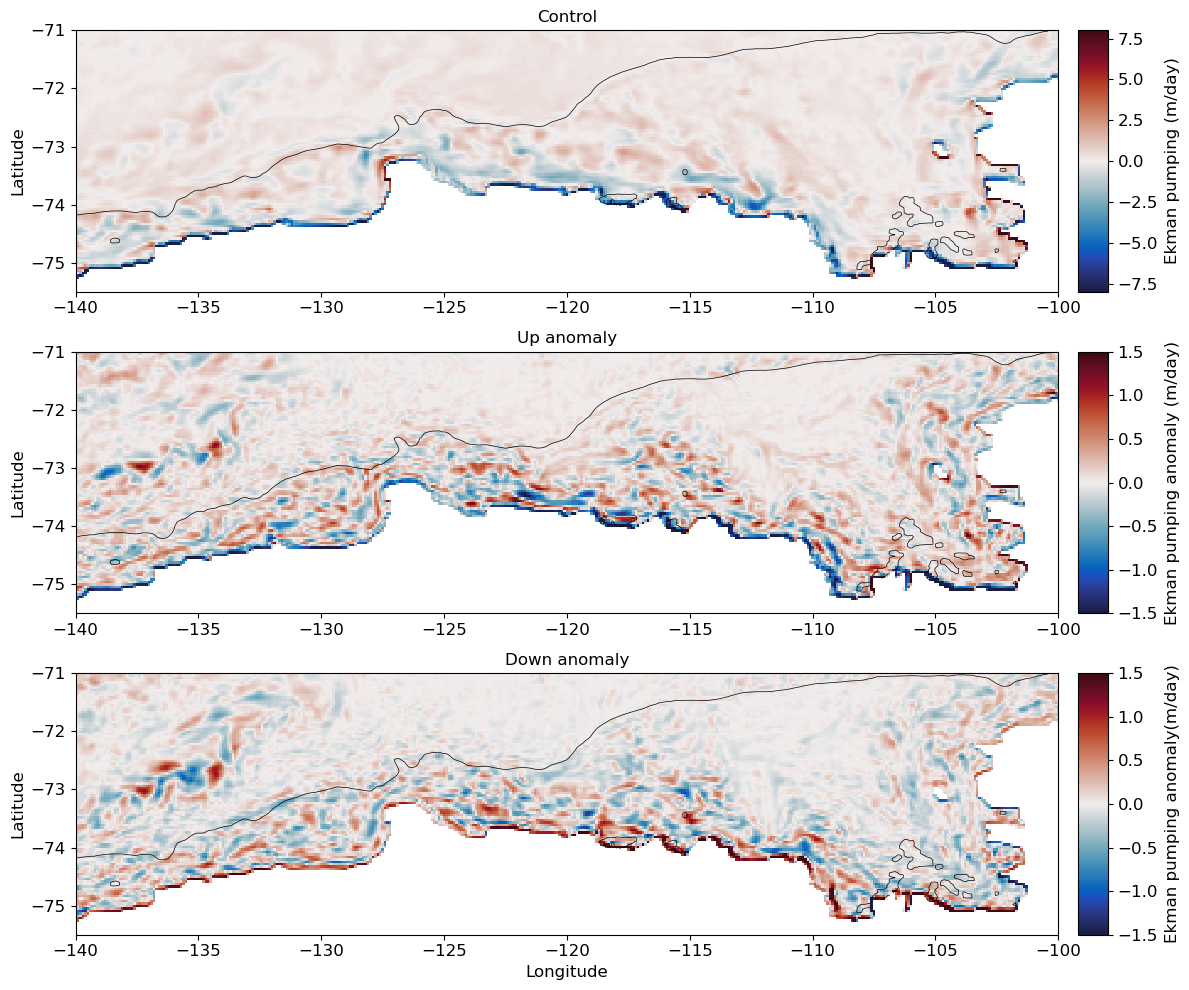

In [18]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Control',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con,cmap=cmocean.balance,vmin=-8,vmax=8)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Up anomaly',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up-ekman_con,cmap=cmocean.balance,vmin=-1.5,vmax=1.5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
plt.title('Down anomaly',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down-ekman_con,cmap=cmocean.balance,vmin=-1.5,vmax=1.5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly(m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_'+start_time[:4]+'_'+end_time[:4]+'.png'
plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Compare to Paul's xgcm method:
I haven't been able to get this to work without it spreading nans outwards from the coast.

In [11]:
import xgcm

folder = '/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')
ds = xr.merge([tau_x_con, tau_y_con, grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X'])

ekman_xgcm = ( grid.interp( grid.diff(ds.tau_y/f, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.tau_x/f, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )
s_day=60*60*24
rho0 = 1035.
ekman_xgcm = ekman_xgcm/rho0*s_day

In [165]:
# Example region showing land/ocean cells:
ht[310:320,:4].values

array([[      nan,       nan,       nan,       nan],
       [167.96666, 167.96666, 145.77774,       nan],
       [259.31668, 279.13333, 322.55   , 326.03638],
       [339.98334, 371.3644 , 398.73334, 398.73334],
       [410.89584, 454.3845 , 488.23334, 472.65   ],
       [461.35   , 491.8859 , 532.61664, 532.61664],
       [468.48334, 491.8859 , 527.63336, 513.56665],
       [419.66666, 431.81668, 457.68332, 474.5    ],
       [371.3644 , 371.3644 , 415.78333, 464.41666],
       [347.6    , 391.78333, 455.11667, 489.81668]], dtype=float32)

In [166]:
# Ekman pumping using the xgcm method:
# See this has lost some ocean points next to land:
ekman_xgcm[310:320,:4].values

array([[        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [-5.02434253, -6.23527346,         nan,         nan],
       [ 1.577118  ,  1.35566241, -0.28250894, -4.16464561],
       [-1.01977741, -1.02328422, -1.10111215, -1.62585526],
       [-2.67315205, -3.40031505, -4.01746557, -3.95800571],
       [-0.70130433, -0.60833514, -0.63276809, -1.02716915],
       [ 1.37251113,  1.82424013,  2.10258679,  1.05124428],
       [-0.43135331,  0.36859111,  1.40188855,  0.97140265],
       [-1.91214104, -0.1707298 ,  1.72109699,  1.15455567]])

In [164]:
# Ekman pumping using method 2 from Cosima Recipes, and being careful not to spread nans from land:
# Though this isn't quite as close the xgcm method as I would like...
ekman_con[310:320,:4].values

array([[         nan,          nan,          nan,          nan],
       [-22.018144  , -19.7501393 ,  -8.90709248,          nan],
       [ -5.02516542,  -6.23587633, -13.27084182, -20.64673975],
       [  1.57651293,   1.3553484 ,  -0.28272017,  -4.1655342 ],
       [ -1.02010643,  -1.02350746,  -1.10158725,  -1.62704638],
       [ -2.67351698,  -3.40066175,  -4.0180455 ,  -3.95893799],
       [ -0.7017601 ,  -0.60864797,  -0.63297043,  -1.02764676],
       [  1.37202472,   1.82402702,   2.10285208,   1.05124892],
       [ -0.43206949,   0.36836775,   1.40248435,   0.97166165],
       [ -1.91311104,  -0.17102294,   1.7218666 ,   1.15474937]])

## Try applying shelf mask and averaging over a small region.

In [20]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [21]:
lon_slice = slice(-140,-100)

# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# multiply mask by area:
shelf_mask_area = shelf_mask*area_t

Amundsen_area_sum = shelf_mask.sum('xt_ocean').sum('yt_ocean')

# apply to data and area weight:
ekman_con_sum = (ekman_con*shelf_mask).sum('xt_ocean').sum('yt_ocean')/Amundsen_area_sum

ekman_up_sum = (ekman_up*shelf_mask).sum('xt_ocean').sum('yt_ocean')/Amundsen_area_sum

ekman_down_sum = (ekman_down*shelf_mask).sum('xt_ocean').sum('yt_ocean')/Amundsen_area_sum

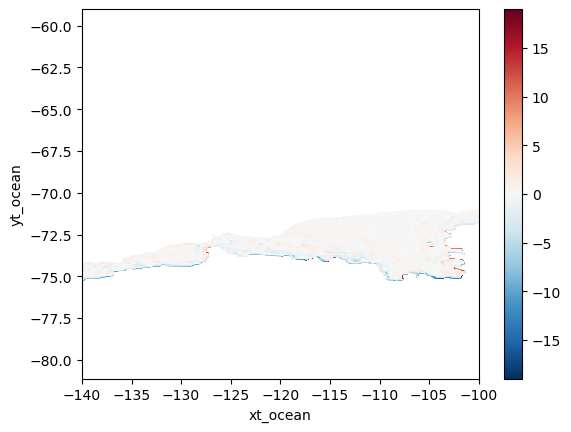

In [29]:
(ekman_con*shelf_mask).plot()

In [24]:
ekman_con_sum

<xarray.DataArray ()>
array(-0.03157281)

In [28]:
ekman_up_sum - ekman_con_sum

<xarray.DataArray ()>
array(-0.00246251)

In [27]:
ekman_down_sum - ekman_con_sum

<xarray.DataArray ()>
array(0.00242991)